# Logistic Regression

* Topic: Supervised machine learning
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Clarke, Simon Bowly, Kaustav Das
* Version: 4.0.1

In this lesson we will discuss the logistic regression classifier model. This is closely related to linear regression, but predicts probabilities for **classification**, instead of continuous values. We will use the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which is built in to `seaborn` and `sklearn`. 

We will firstly explain how logistic regression can be used to classify binary data, by considering just one species of iris. We will then explain how the accuracy of logistic regression can be evaluated using a range of methods. The exercise will then consider multiclass logistic regression.

First, import various libraries which we require.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
import pandas as pd

## Exploratory Data Analysis

We now import the iris data set and undertake some exploratory data analysis. The data frame has 150 rows and 5 columns. Viewing the header shows there are four features: sepal_length, sepal_width, petal_length and petal_width. These are all in cm. There is one target variable, which is the species of iris.

In [21]:
iris = sns.load_dataset('iris') # load the dataset from seaborn
print(f'Shape of the iris dataset is {iris.shape}') # display the shape of the data
iris.head() # display the first few lines

Shape of the iris dataset is (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


By viewing the statistics we see that there are no missing entries and the standard deviation of each column is fairly similar. However, we will normalise the data before modelling.

In [22]:
iris.describe() # show the statistics of the numerical columns

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


The target field is a string, and has three unique values.

In [23]:
iris['species'].unique() # show the unique values of the species column

array(['setosa', 'versicolor', 'virginica'], dtype=object)

Plotting the classification against the first two features, it is apparent that setosa is fairly well separated in feature space, whereas versicolor and virginica have a blurred boundary. Note that the boundary may differ using other features. We would expect that classifiers should be able to easily classify setosa, though the other two species may be a bit more difficult. You can experiment boundaries by changing the features or using `sns.pairplot`.

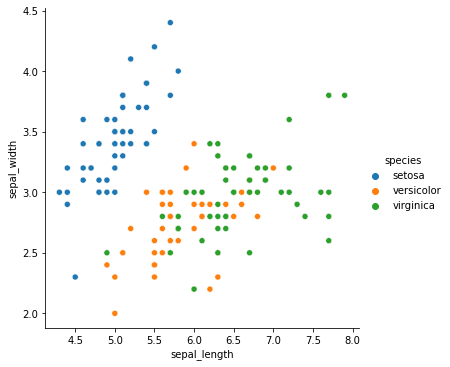

In [24]:
# plot the first two fields of the iris dataset and classify the points based on the species
# hue='species' indicates to classify the points based on the species field
sns.relplot(x="sepal_length", y="sepal_width",hue='species',data=iris);

Since this is a multiclass classification problem, we need to convert the label column to binary columns. In other words, we will need to perform one-hot encoding.

In [25]:
# one-hot encoding

species_one_hots =  pd.get_dummies(iris.species, prefix = 'species')
iris = pd.concat([iris, species_one_hots], axis = 1)

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_setosa,species_versicolor,species_virginica
0,5.1,3.5,1.4,0.2,setosa,1,0,0
1,4.9,3.0,1.4,0.2,setosa,1,0,0
2,4.7,3.2,1.3,0.2,setosa,1,0,0
3,4.6,3.1,1.5,0.2,setosa,1,0,0
4,5.0,3.6,1.4,0.2,setosa,1,0,0


Now we create a features dataframe XX which comprises the first four columns of the iris data set, and a target series Y which is the binary column we have just created to identify whether or not the species is versicolor. Here we will used the normalized version of the features matrix X.

In [26]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# the dataframe XX will have the first 3 columns (0 to 3) of iris, and Y will have the binary classification column for versicolor
XX = iris.iloc[:, :4]
Y =  iris.species_versicolor 

# # Instantiate the MinMaxScaler (or StandardScaler). 
scaler = MinMaxScaler()
# scaler = StandardScaler()

# X is the normalised version X
X = pd.DataFrame(data = scaler.fit_transform(XX), columns = XX.columns)
X.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.440556,0.467458,0.458056
std,0.230018,0.181611,0.299203,0.317599
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [27]:
X

,sepal_length,sepal_width,petal_length,petal_width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


Then we split these data sets into training and testing sets.

In [28]:
from sklearn.model_selection import train_test_split # import the splitting method from sklearn

# split the data into 80% training and 20% testing, random_state=0 ensures that the results are repeatable
X_train,X_test,y_train,y_test = train_test_split(
    X, Y, test_size = 0.2, random_state=0
)  

## Logistic Regression

We can now introduce the sigmoid or logistic function. This is a defined as

$$ f(x) = \displaystyle{\frac{1}{1+e^{-x}}}, $$

and is a smooth, one-to-one (every x value gives a unique y value) function with the domain $(-\infty,\infty)$ and range $(0,1)$. If x is negative then the logistic function is less than 0.5 but greater than 0, while if x is positive the logistic function is greater than 0.5 but less than 1.

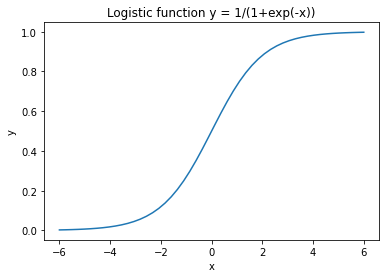

In [29]:
xa = np.linspace(-6,6) # create a linear array of x values between -6 and 6
plt.plot(xa,1/(1+np.exp(-xa))); # plot the logistic function 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Logistic function y = 1/(1+exp(-x))');

Logistic regression assumes that the data is described by $N$ instances or points, and at each of these there are $P$ features. At each point from $i=1,2,...,N$, the probability of the data being classified as true or false is modelled by

$$ y_i = f(c_0 + c_1 x_{i,1} + c_2 x_{i,2} + \cdots + c_P x_{i,P}), $$

where $f$ is the **logistic** function. The algorithm then aims to calculate the coefficients $c_1$, $c_2$,..., $c_P$ and the intercept $c_0$. For linear regression the coefficients were calculated by minimizing the sum of the square of the errors. This is equivalent to maximimizing the likelihood of the observed data, assuming the data points are distributed with mean 0 and some standard deviation $\sigma$. Therefore, the observed data is the most likely data. For logistic regression these two statements are no longer equivalent, however, the coefficients can be calculated by again maximizing the likelihood of the observed data. This is done by using optimization algorithms.

The process for logistic regression using `sklearn` is the same as the other models we have so far considered, however the options change when instantiating the model. We will use the default optimisation solver `lbfgs` to fit the data and show the model partameters.

In [30]:
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model

# instantiate the model (using the default parameters)
# penalty='none' implies no regularisation and solver='lbfgs' is the default solver
# different solvers can be used, dependent on the type of penalties that are implemented
logreg = LogisticRegression(solver = 'lbfgs', penalty='none')
logreg.fit(X_train, y_train) # fit the training data to the model

print(f'Model coefficients are {np.round(logreg.coef_, 3)}') # print the model coefficients c1,...,c4
print(f'Model intercept is {np.round(logreg.intercept_,3)}') # print the model intercept c0

Model coefficients are [[-3.165 -5.728 10.925 -8.223]]
Model intercept is [1.401]


Next we investigate the probabilities that are output. The second column, which is the probability of correctly picking the species, is the output of the logistic function. Since the problem is binary, the first column is just 1 minus the second column. 

In [31]:
y_preda = logreg.predict_proba(X_test) # calculate the probabilities for the test features
# print out the probability table with a header
print('Probability DataFrame for testing set is:')

probs = pd.DataFrame(
    data = y_preda, 
    columns = ['p', '1-p']
)

probs

Probability DataFrame for testing set is:


,p,1-p
0,0.892437,0.107563
1,0.130073,0.869927
2,0.989088,0.010912
3,0.353257,0.646743
4,0.877921,0.122079
5,0.918701,0.081299
6,0.949047,0.050953
7,0.782455,0.217545
8,0.530990,0.469010
9,0.656452,0.343548


Using a classification threshold of 0.5, i.e., $p>0.5$ indicates true and $p<0.5$ indicates false, the probabilities are then used to predict the target test values, which can be compared against the actual target test values. Looking at the below plot, we can see there are correct predictions at (1,1) (true positives) and (0,0) (true negative), but there are also false positives at (1,0) and false negatives at (0,1). False positives indicates that the model incorrectly predicts a positive value, similarly false negatives indicates that the model incorrectly predicts a negative value.

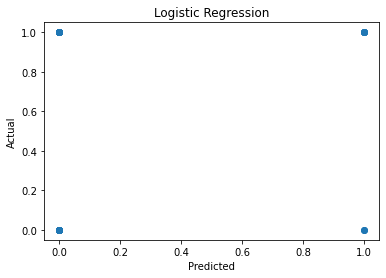

In [32]:
y_pred = logreg.predict(X_test) # calculate the predicted values of the model for the test features

plt.scatter(y_pred, y_test) # plot the predicted values against the actual test values
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.title('Logistic Regression');

To determine the number of correct predictions, false positives and false negatives, we can construct a confusion matrix. From the confusion matrix it can be seen that there are 15 true negatives, 5 true positives, 2 false positives where versicolor was incorrectly predicted, and 8 false negatives, where the other species was incorrectly predicted. The false positive and negatives will typically relate to the virginica species, rather than setosa.

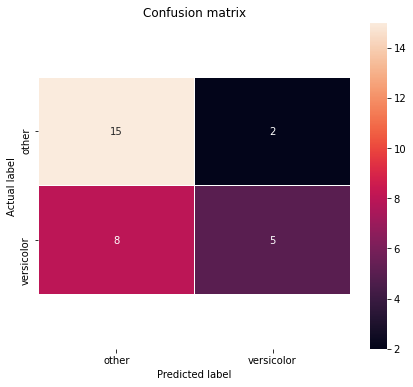

In [33]:
from sklearn.metrics import confusion_matrix # import the confusion matrix function

cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values

# create a dataframe from the confusion matrix with the column and row names being the class_names
class_names=['other', 'versicolor'] # names of the binary classes for plotting
cmatrix = pd.DataFrame(
    data = cnf_matrix,
    columns=class_names,
    index=class_names
)

f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# adjust the bottom and top of the figure, so we can view all of it
bottom, top = ax.get_ylim()  # get the y axis limits
ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

We can calculate various scores to determine the accuracy of the classifier. Remember:

* Accuracy: proportion of all predictions that were correct.
* Precision: proportion of positive predictions which were correct.
* Recall: proportion of actual positive results which were correctly identified.

Mathematically:

- Accuracy = (TP + TN)/(TP + TN + FP + FN).
- Precision = TP/(TP + FP).
- Recall = TP/(TP + FN).

The precision and recall scores give an indication of how well the algorithm is able to pick positive samples, whereas the accuracy gives an indication of how well the algorithm can predict correct samples overall.

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 

print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_pred):.3f}')

Accuracy: 0.667
Precision: 0.714
Recall: 0.385


To further quantify the accuracy of the classifier we can construct a Response Operating Characteristic (ROC) curve, which plots the false positive rate (FPR) against the true positive rate (TPR) as the classification threshold is changed. The TPR is the same as the recall score, while the FPR is the number of false positives divided by the false positives plus true negatives. For a perfect classifier we would expect that TPR=1 and FPR=0. We have considered up until this point a classification threshold of 0.5. If the classification threshold is very high (close to 1), then we are not going to flag any positive responses, so TPR=0 and FPR=0. If the classification threshold is very low (close to 0), then we will only flag positive responses and TPR=1 and FPR=1. Hence if our classifier is good, as the threshold changes the ROC curve will hug the left and top boundaries of the figure. If this occurs the area under the ROC curve (AUC) will approach 1. Therefore classifiers can be compared for a particular problem by measuring the AUC. Any classifier which is below the line y=x and has AUC less than 0.5 will be useless. 

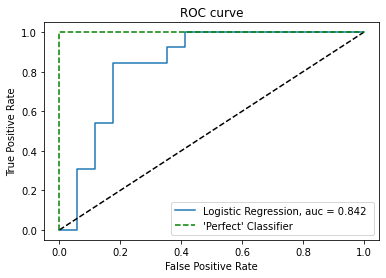

In [35]:
# import the functions to calculate the parameters for the ROC curve and the AUC
from sklearn.metrics import roc_curve, roc_auc_score 

y_pred_proba = logreg.predict_proba(X_test)[::,1] # extract the second column of the model probabilities 

# calculate the false positive and true positive rates as the threshold is varied, we don't use thresholds
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba) # calculate the area under the ROC curve (AUC)

# plot the FPR vs TPR and format label with AUC to 3 decimal places
plt.plot(fpr,tpr,label="Logistic Regression, auc = %0.3f " % auc)
plt.plot([0,1],[0,1],'k--') # plot x = y for comparison
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best');